## MO436 - Tópicos em Aprendizado de Máquina: Reinforcement Learning - 2s2020

### Projeto 2
Mauricio de Sousa Araujo, 184477 | Raysa Masson Benatti, 176483

#### Vídeo

A síntese dos resultados, bem como sua demonstração visual em cada método, podem ser acessados [neste vídeo](https://youtu.be/PHjCign3q_o).

#### Introdução

O objetivo deste trabalho é aplicar métodos de <b>aprendizado por reforço profundo</b> para resolver um problema definido pelo grupo. No nosso caso, optamos por estudar e resolver o problema do <b>CartPole</b>. As configurações do ambiente seguem o mesmo padrão usado no Projeto 1. 
    
Conforme definido por Barto, Sutton e Anderson [[1]](#Referências), trata-se de um sistema simulado que representa um pêndulo invertido. Nessa simulação, o <b>agente</b> é um carrinho que se move em um trilho sem atrito de uma dimensão, para a esquerda ou direita; ligado ao carrinho, encontra-se uma estaca, que se move angularmente, em sentido horário ou anti-horário. O objetivo do problema é colocar o carrinho em movimento de modo que a estaca (pêndulo) permaneça ereta. 

Para atingir esse objetivo, devemos controlar as variáveis do modelo. São quatro variáveis, que definem os <b>estados</b> do sistema: (1) a posição <b>p</b> do carrinho no trilho; (2) a velocidade <b>v</b> do carrinho; (3) o ângulo <b>a</b> que a estaca forma com o eixo vertical do carrinho; (4) a velocidade angular <b>va</b> de movimento da estaca.

O modelo tem duas <b>ações</b> possíveis: movimentar o carrinho sobre o trilho para a esquerda ou para a direita.

Um estado desse sistema é <b>terminal</b> nas seguintes situações: (1) se o módulo do ângulo <b>a</b> é maior que 12 graus (o que representa, na prática, a queda da estaca); (2) se o centro do carrinho atinge alguma borda do ambiente; (3) se a quantidade máxima de episódios definida é atingida. O estado terminal (1) é considerado fracasso; os estados terminais (2) e (3) são bem-sucedidos e representam o objetivo do problema <b>se</b>, quando são atingidos, o carrinho se movimenta com a estaca ereta. Por padrão, a cada ação tomada, o ambiente fornece ao agente um <i>feedback</i> --- ou <b>recompensa</b> --- no valor de 1; se a ação resulta em um estado (1) ou (2), o ambiente enviará um <i>failure signal</i> através da variável booleana ``done``, cujo valor será modificado de ``False`` para ``True``. Caso a ação faça a estaca cair (estado (1)), a recompensa será zero.

O ambiente se caracteriza como <b>estocástico</b>, pois não é possível determinar o resultado a partir de um estado atual, e <b>episódico</b>, pois o agente pode tomar qualquer uma das ações disponíveis a qualquer momento, sem que uma ação afete as demais. 


Para implementar e explorar o problema, usamos o ambiente CartPole-v1 do <i>toolkit</i> OpenAI Gym [[2]](#Referências). 

In [1]:
import gym

Foram implementados e comparados dois métodos: <b>DQN</b> (off-policy, value-based) e <b>A2C</b> (on-policy, actor-critic).

#### DQN

DQN (Deep Q-Network) é uma rede neural convolucional treinada para um algoritmo Q-learning [[3]](#Referências). Trata-se de um método off-policy e value-based de aprendizado por reforço profundo.

Aqui, implementamos o DQN da seguinte forma: criamos duas redes idênticas, uma denominada predict_net($Q^{predict}_{w}$) e a outra target_net($Q^{target}_{w}$), em que $w$ representa sua parametrização. A entrada da rede é uma estado representado por 4 números (conforme descrito na introdução), e a saída é a expectativa de reward futuro para cada razão. Então, treinamos as redes por um número de $n$ episódios segundo o algoritmo: 

1.   Selecionar uma ação $a_t$ de acordo com a política $\epsilon-greedy$ sobre a rede  $Q^{predict}_{w}$;
2.   Armazenar a transição $(s_t,\ a_t, \ r_{t+1}, \ s_{t+1})$ em um $\textit{replay memory D} $;
3.   Retirar randomicamente $\textit{mini-batch}$ de $\textit{D}$ transições: $(s,a,r,s')$;
4.   Computar o $\textit{target value}$ de uma amostra: $r\ + \ \gamma max_{a'} Q^{target}_w(s',a')$;
5.   Otimizar com MSE:  $$Loss = E_{s,a,r,s'\sim  D}[(r\ + \ \gamma max_{a'} Q^{target}_w(s',a')-Q_w^{prediction}(s,a))^2]$$ (podemos subistituir a expectativa $E$ por uma média ou por um sample utilizando SGD para atualizar os pesos).

Vale lembrar que, efetivamente, a rede treinada é $Q^{predict}_{w}$; a rede $Q^{target}_{w}$ é atualizada com os pesos da rede ``predict`` a cada 10 episódios. Ou seja: durante o treinamento, deixamos a rede ``target`` com suas camadas congeladas.

Configuração do algoritmo:
1. Arquitetura de rede:
    1.  $\textit{Input}$ com tamanho igual a 4; 
    2.  Após o $\textit{input}$, duas camadas $\textit{Dense}$ com 124 neurônios com função de ativação ReLU;
    3.  Por fim, uma camada linear de $\textit{output}$ de tamanho igual a 2, representando a expectativa de retorno para as duas ações possíveis;
    4. A $\textit{loss}$ utilizada foi MSE.
2. Constantes:
    1. Treinamos sobre 40 eposódios;
    2. Nossa $\textit{replay memory} $ tem tamanho igual a 1000 e retiramos $\textit{batchs} $ de tamanho igual a 32;
    3. $\gamma = 0.95$;  
    4. Atualizamos $Q^{target}_{w}$ a cada 10 épocas.
3. Métricas de avaliação:
   Para sabermos se modelo está aprendendo a equilibrar o bastão, geramos uma política $\epsilon-greedy$ com base na função $Q^{target}_{w}$, ou seja, tomamos a ação que gera a maior expectativa de $\textit{reward}$, dado um estado, e comparamos tal política com a política randômica.
   Além disso, plotamos o gráfico de $\textit{score}$. Esse gráfico representa a quantidade de ações que a política $\epsilon-greedy$ fez mantendo o bloco entre estados válidos para um único sample de estados iniciais válidos.
   
Os experimentos foram executados localmente; o código e os resultados são reproduzidos aqui.

In [2]:
import random
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
from collections import namedtuple

In [3]:
#Constantes
batch_size = 32
TARGET_UPDATE = 10
EPISODES = 40
GAMMA = 0.95
SIZE_REPLAY = 1000

#Data Structure
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = GAMMA    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        
        
        self.memory = ReplayMemory(SIZE_REPLAY)
        self.predict_net = self._build_model()
        self.target_net = self.disable_training_network( self._build_model() )
        

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def disable_training_network(self, model):
        #Congelamos a rede
        for k,v in model._get_trainable_state().items():
            k.trainable = False
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
            
    def salve_model(self,model, path):
        model.save_weights(path)
        
    def load_model(self, model, path):
        model.load_weights(path)
        return model

    def memorize(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def act(self, state, model):
        #Epsilon-Greedy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def optimize_model(self, batch_size):
        
        minibatch = self.memory.sample(batch_size)        
        for t in minibatch:
            state, action, reward, next_state, done = t.state, t.action, t.reward, t.next_state, t.done
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.target_net.predict(next_state)[0]))
            target_f = self.predict_net.predict(state)
            target_f[0][action] = target
            self.predict_net.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQN(state_size, action_size)

Segue o treinamento do modelo:

In [ ]:
scores = []
for e in range(EPISODES): 
    state = np.reshape(env.reset(), [1, state_size])    
    for time in range(500):
        action = agent.act(state, agent.predict_net)
        new_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        new_state = np.reshape(new_state, [1, state_size])
        
        agent.memorize(state, action, new_state, reward,done)
        
        state = new_state
        
        if done:
            scores.append(time)
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, EPISODES, time, agent.epsilon))
            break
        if len(agent.memory) > batch_size:
            agent.optimize_model(batch_size)
    if e % TARGET_UPDATE == 0:
        agent.salve_model(model=agent.predict_net, path='model_DQN')
        agent.load_model(model=agent.target_net, path='model_DQN')

#Damos um checkpoint de saída 
if e % TARGET_UPDATE == 0:
    agent.salve_model(model=agent.predict_net, path='model_DQN')
    agent.load_model(model=agent.target_net, path='model_DQN')

Avaliamos o modelo observando a evolução do score ao longo do treinamento.

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize = (15, 5))
plt.plot(scores, label = 'score')
plt.legend()
plt.title('Score versus Episodes')
plt.show()

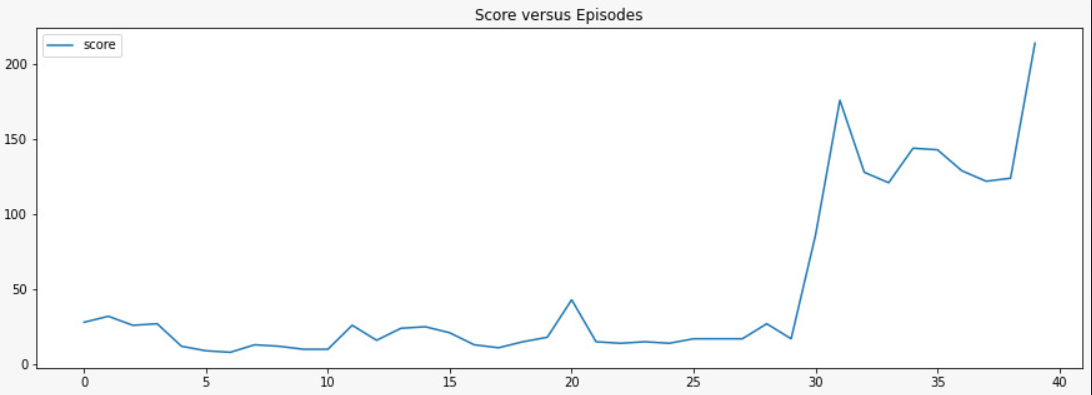

Em seguida, calculamos: (a) a média de ações para política $\epsilon-greedy$ com base na função $Q^{target}_{w}$; (b) a média de ações para política randômica.

In [ ]:
n=100
soma=0
for i in range(n):
    state = np.reshape(env.reset(), [1, state_size])  
    k=0  
    for time in range(500):
        action = agent.act(state, agent.target_net)
        new_state, reward, done, _ = env.step(action)
        new_state = np.reshape(new_state, [1, state_size])
        state = new_state
        k+=1
        if done:
            soma+=k      
            break
print(f'Média de ações para {EPISODES} episódios é {soma/n}')

In [ ]:
n=100
soma=0
for i in range(n):
    state = np.reshape(env.reset(), [1, state_size])  
    k=0  
    for time in range(500):
        action_random = env.action_space.sample()
        new_state, reward, done, _ = env.step(action_random)
        new_state = np.reshape(new_state, [1, state_size])
        state = new_state
        k+=1
        if done:
            soma+=k      
            break
print(f'Média de ações para política randômica é {soma/n}')

<b>Para carregar o modelo salvo:</b> O trecho de código abaixo serve para pegar diretamente os pesos da rede treinada. Para carregar, são necessários os arquivos dos pesos no diretório corrente. Eles podem ser acessados [aqui](https://github.com/ra-ysa/reinforcement_learning). 

In [ ]:
model = Sequential()
model.add(Dense(24, input_dim=4, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse',
              optimizer=Adam())

model.load_weights('model_DQN')

soma=0
n=100
for i in range(n):
    state = np.reshape(env.reset(), [1, state_size])    
    done=False
    k=0
    while(not done):
        action = np.argmax(model.predict(state),axis=1)[0]
        next_state, reward, done, info = env.step(action) #obs é um vetor com 4 valores, Position, Cart Velocity, Angle, Angle Velocity
        next_state = np.reshape(next_state, [1, state_size])  
        state = next_state
        k+=1
    mean+=k

print(f'Média de: {soma/n} ações antes de cair')

#### A2C

A2C é a abreviação de <b>Advantage Actor Critic</b>, uma variação síncrona e determinística do método A3C (Asynchronous Advantage Actor Critic) [[4]](#Referências). Trata-se de métodos <b>actor-critic</b>, isto é, em que a política é o <b>ator</b> (responsável por selecionar ações) e a função valor é o <b>crítico</b> (responsável por "criticar" as ações tomadas pelo ator). O aprendizado ocorre on-policy.

Usando a biblioteca ``stable_baselines``, implementamos o algoritmo usando os seguintes parâmetros:

- 'MlpPolicy' --- isto é, estrutura actor-critic com MLP (multilayer perceptron de 2 camadas de 64 neurônios) como aproximador de função;
- Taxa de aprendizado de 0.001; 
- 25000 steps para treinamento. 

Foram testados dois valores do fator de desconto (gamma): 0.5 e 0.99. (Quanto maior o valor de gamma, maior é a importância das recompensas distantes.)

Os experimentos foram executados localmente; o código e os resultados são reproduzidos aqui. Os logs gerados por cada treinamento, por serem longos, foram omitidos para facilitar a leitura do notebook; [aqui](https://github.com/ra-ysa/reinforcement_learning) se encontra seu conteúdo completo. 

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import A2C

In [ ]:
def train(env, gamma, learning_rate):
    model = A2C('MlpPolicy', env, learning_rate, verbose=1)
    init_time = time.time()
    model.learn(total_timesteps=25000, log_interval=50)
    final_time = time.time()
    model.save("a2c_cartpole")
    print("Tempo total de treinamento: {} segundos".format(final_time - init_time))
    return model

O trecho abaixo executa a demonstração (visualização) do ambiente, disponível no vídeo referenciado no início do relatório.

In [ ]:
def demonstrate(model):
    del model # remove to demonstrate saving and loading
    model = A2C.load("a2c_cartpole")
    obs = env.reset()
    for i in range(1000): 
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        env.render()

A avaliação é feita pela evolução dos valores de loss, obtidos a partir do log do treinamento.

In [ ]:
def evaluate(log, plot_name):
    '''
    A partir do log de treinamento, plota os valores da loss
    '''
    timesteps = []
    losses = []

    file = open(log, 'r')
    for line in file:
        if ("total_timesteps" in line):
            timesteps.append(float(str.strip(line[22:32])))
        if ("value_loss" in line):
            losses.append(float(str.strip(line[22:32])))

    fig, ax = plt.subplots()
    ax.plot(timesteps, losses)
    ax.set(xlabel='Timesteps', ylabel='Loss',
       title='Evolução do valor da loss ao longo do treinamento')
    ax.grid()
    fig.savefig(plot_name)
    plt.show()

In [ ]:
env = make_vec_env('CartPole-v1', n_envs=1)
learning_rate=0.001
gamma = 0.5

trained_model = train(env, gamma, learning_rate)
demonstrate(trained_model)
log = "log1.txt"
evaluate(log, "loss1.png")

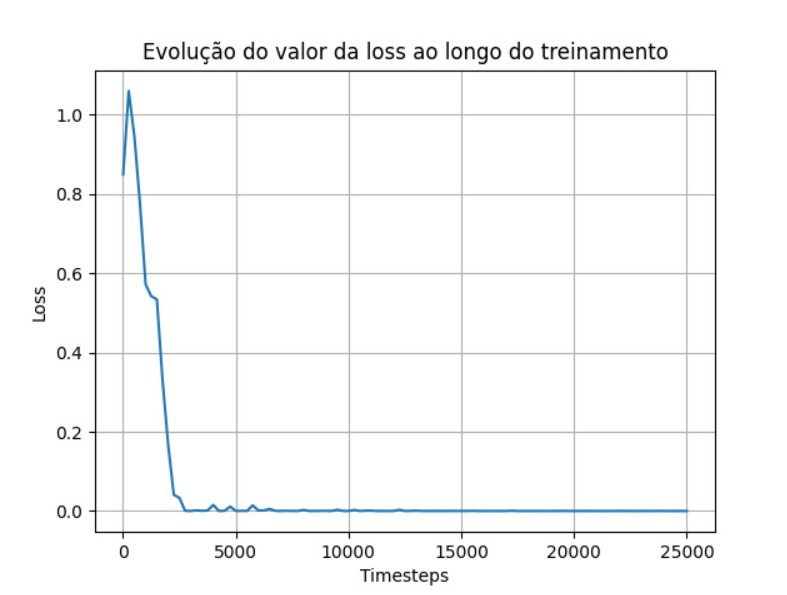

Em seguida, executamos o mesmo experimento para gamma = 0.99. 

In [ ]:
gamma = 0.99

trained_model = train(env, gamma, learning_rate)
demonstrate(trained_model)
log = "log2.txt"
evaluate(log, "loss2.png")

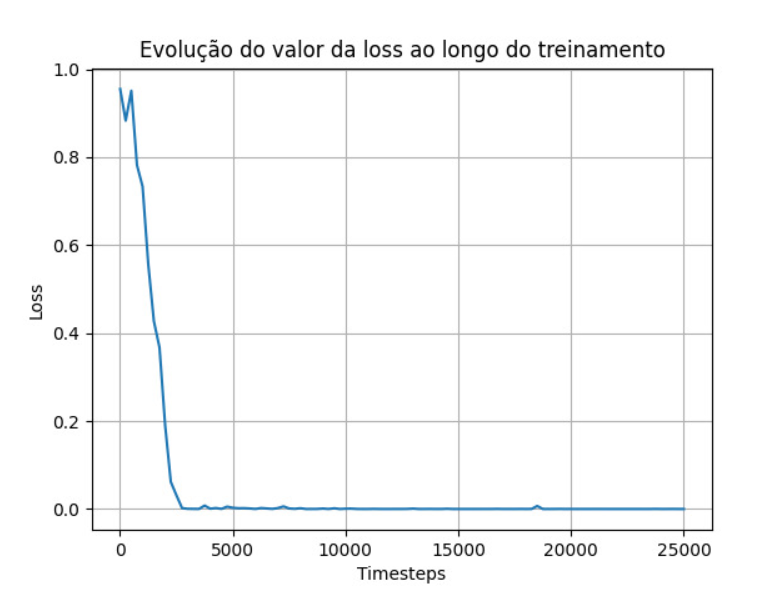

#### Síntese dos resultados e discussões

- <b> DQN </b>:

O modelo apresentou um resultado satisfatório, embora possivelmente prejudicado pela baixa quantidade de episódios de treinamento. Embora não registrado no código, o tempo de treinamento, para 40 episódios, foi de mais de 2 horas, o que inviabilizou a realização de experimentos com treinamento maior. O valor do score salta a partir de 30 episódios, mas ainda apresenta oscilações; possivelmente, com mais episódios veríamos uma tendência de convergência mais clara. Os valores atingidos, porém, são aceitáveis (o problema pode ser considerado solucionado quando o score chega a 195 e se mantém próximo disso). 

A política greedy se mostrou consideravelmente melhor que a política randômica, com média de 131.14 ações executadas (contra 21.39) - o que demonstra a adequação do modelo para resolver este problema.

- <b> A2C </b>:

O modelo apresentou um resultado satisfatório, com convergência em aproximadamente 2500 passos de treinamento. O tempo de aprendizado foi consideravelmente mais rápido que o do DQN; notamos, porém, que DQN seguiu uma implementação passo a passo, enquanto para A2C foi utilizada uma biblioteca otimizada, o que certamente tem influência nesse resultado.

Não houve diferença significativa entre A2C com gamma=0.5 e A2C com gamma=0.99. Experimentos preliminares (não descritos aqui) usando outras configurações de redes MLP para aproximar a função também não mostraram diferenças importantes no resultado. Entendemos isso como indicativo de que: (a) na dinâmica actor-critic, diferenciar o peso das rewards ao longo do tempo parece ter menos relevância que em outros modelos; (b) MLP é uma arquitetura de rede adequada para realizar a tarefa proposta aqui. 

- <b>Comparação entre algoritmos</b>:

Abaixo, comparamos os métodos implementados aqui com os algoritmos implementados e avaliados no Projeto 1 (Monte Carlo, Q-learning e Sarsa-Lambda). 

|           |# episódios necessários para convergência| Tempo de treinamento|Resultado|
|-----------|---------------------------------|----------|----------|
|Monte Carlo|aprox. 10000|1.43 segundos (1000 episódios)|Satisfatório, com convergência para solução|
|Q-learning|aprox. 200|296 segundos (1000 episódios)|Satisfatório, com convergência para solução|
|Sarsa-Lambda|N/A|1468 segundos (1000 episódios)|Não houve convergência|
|DQN|Não foi possível avaliar|>2 horas (40 episódios)|Parcialmente satisfatório|
|A2C|aprox. 2500|~23 segundos (25000 episódios)|Satisfatório, com convergência para solução|

Embora o DQN não tenha exibido um padrão claro de convergência, a avaliação do modelo sugere que ele teria convergido com mais episódios para treinamento. Apenas Sarsa-Lambda exibiu um resultado inferior nesse sentido - já que, com o treinamento disponível, não exibiu nenhum padrão de aprendizado. Monte Carlo Control, embora tenha apresentado convergência, precisou de 10000 episódios para tal - o que foi possível devido à rapidez de seu treinamento; também notamos que, para 1 milhão de episódios, seu valor médio de ações executadas antes do fracasso é similar ao que foi atingido, agora, pelo DQN (que apresentou um valor aceitável de ações com somente 40 episódios). 

Em todos os métodos exceto Sarsa-Lambda, o objetivo de aprendizado foi atingido. Em particular, os aproximadores de função usados aqui têm como vantagem a dispensa da necessidade de discretizar o ambiente. No caso da formulação A2C, apesar de demandar mais episódios que Q-learning para convergir, seu treinamento rápido, aliado à possibilidade de execução sem discretização, representou uma vantagem.

Neste problema, o aprendizado off-policy se revelou menos eficiente que on-policy; não se deve perder de vista, porém, que o uso de uma biblioteca otimizada para o último pode ter influenciado este resultado.  

#### Descrição das tarefas do grupo

As tarefas foram realizadas conforme descrito abaixo: 

- Mauricio: Estudo, implementação, testes e visualizações do método DQN; Escrita e organização de partes do relatório; Produção do vídeo.
- Raysa: Estudo, implementação, testes e visualizações do método A2C; Escrita e organização de partes do relatório; Produção do vídeo.

#### Referências

[1] A. G. Barto, R. S. Sutton and C. W. Anderson, "Neuronlike adaptive elements that can solve difficult learning control problems," in <i>IEEE Transactions on Systems, Man, and Cybernetics</i>, vol. SMC-13, no. 5, pp. 834-846, Sept.-Oct. 1983, doi: 10.1109/TSMC.1983.6313077.

[2] OpenAI Gym: CartPole-v0. https://gym.openai.com/envs/CartPole-v0/ 

[3] V. Mnih et al. Playing Atari with Deep Reinforcement Learning. 2013. https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

[4] OpenAI Baselines: ACKTR & A2C. https://openai.com/blog/baselines-acktr-a2c/. Documentação em https://stable-baselines.readthedocs.io/en/master/modules/a2c.html. 